# Querying, reading in, exploring, and plotting Gaia DR3 BP RP Coefficients and Spectra

## Catherine Manea, University of Texas at Austin

This notebook queries the Gaia Archive for the XP Continuous Spectra of a subset of APOGEE stars that *in principle* evenly sample the APOGEE parameter space.

Based off tutorial found here: https://www.cosmos.esa.int/web/gaia-users/archive/datalink-products

In [144]:
# imports (make sure you have astroquery installed: 
# https://astroquery.readthedocs.io/en/latest/)

import numpy as np
from astropy.table import Table, vstack
import matplotlib.pyplot as plt
from astroquery.gaia import Gaia
from astropy.table import Table
from astropy.table import join
import time

First, we define relevant Gaia archive DataLink Query functions (directly from tutorial):

In [2]:
def extract_dl_ind(datalink_dict, key, figsize = [15,5], fontsize = 12, linewidth = 2, show_legend = True, show_grid = True):
    ""
    "Extract individual DataLink products and export them to an Astropy Table"
    ""
    dl_out  = datalink_dict[key][0].to_table()
    if 'time' in dl_out.keys():
        plot_e_phot(dl_out, colours  = ['green', 'red', 'blue'], title = 'Epoch photometry', fontsize = fontsize, show_legend = show_legend, show_grid = show_grid, figsize = figsize)
    if 'wavelength' in dl_out.keys():
        if len(dl_out) == 343:  title = 'XP Sampled'
        if len(dl_out) == 2401: title = 'RVS'
        plot_sampled_spec(dl_out, color = 'blue', title = title, fontsize = fontsize, show_legend = False, show_grid = show_grid, linewidth = linewidth, legend = '', figsize = figsize)
    return dl_out


def plot_e_phot(inp_table, colours  = ['green', 'red', 'blue'], title = 'Epoch photometry', fontsize = 12, show_legend = True, show_grid = True, figsize = [15,5]):
    ""
    "Epoch photometry plotter. 'inp_table' MUST be an Astropy-table object."
    ""
    fig      = plt.figure(figsize=figsize)
    xlabel   = f'JD date [{inp_table["time"].unit}]'
    ylabel   = f'magnitude [{inp_table["mag"].unit}]'
    gbands   = ['G', 'RP', 'BP']
    colours  = iter(colours)

    plt.gca().invert_yaxis()
    for band in gbands:
        phot_set = inp_table[inp_table['band'] == band]
        plt.plot(phot_set['time'], phot_set['mag'], 'o', label = band, color = next(colours))
    make_canvas(title = title, xlabel = xlabel, ylabel = ylabel, fontsize= fontsize, show_legend=show_legend, show_grid = show_grid)
    plt.show()


def plot_sampled_spec(inp_table, color = 'blue', title = '', fontsize = 14, show_legend = True, show_grid = True, linewidth = 2, legend = '', figsize = [12,4], show_plot = True):
    ""
    "RVS & XP sampled spectrum plotter. 'inp_table' MUST be an Astropy-table object."
    ""
    if show_plot:
        fig      = plt.figure(figsize=figsize)
    xlabel   = f'Wavelength [{inp_table["wavelength"].unit}]'
    ylabel   = f'Flux [{inp_table["flux"].unit}]'
    plt.plot(inp_table['wavelength'], inp_table['flux'], '-', linewidth = linewidth, label = legend)
    make_canvas(title = title, xlabel = xlabel, ylabel = ylabel, fontsize= fontsize, show_legend=show_legend, show_grid = show_grid)
    if show_plot:
        plt.show()


def make_canvas(title = '', xlabel = '', ylabel = '', show_grid = False, show_legend = False, fontsize = 12):
    ""
    "Create generic canvas for plots"
    ""
    plt.title(title,    fontsize = fontsize)
    plt.xlabel(xlabel,  fontsize = fontsize)
    plt.ylabel(ylabel , fontsize = fontsize)
    plt.xticks(fontsize = fontsize)
    plt.yticks(fontsize = fontsize)
    if show_grid:
        plt.grid()
    if show_legend:
        plt.legend(fontsize = fontsize*0.75)

Next, let's read in the APOGEE training set table (replace with your own data table if desired):

In [133]:
t_apogee_training = Table.read('clean_apogee_sample_1496.fits')

In [137]:
t_apogee_training

GAIAEDR3_SOURCE_ID,APOGEE_ID,Teff,logg,feh,A_v,SNR
int64,bytes30,float64,float64,float64,float64,float64
5494465006512656000,2M06014757-5951510,5194.12255859375,3.3309779167175293,-1.9431999921798706,0.30600249767303467,430.9967041015625
798855537578324992,2M09341699+3614584,5370.431640625,3.4953479766845703,-1.7857999801635742,0.5060817003250122,410.1751708984375
5281650137208867328,2M06531651-6717256,4229.07470703125,0.5284929275512695,-1.8515000343322754,0.7414605617523193,151.5426025390625
2106022408847412224,2M19084163+4352103,4702.80078125,1.4378466606140137,-1.8753999471664429,1.0239241123199463,647.6806030273438
2713357447653288320,2M22515173+0853119,4582.18798828125,1.255357265472412,-1.886299967765808,1.0356868505477905,579.3580932617188
1505148615752865408,2M14130915+4511429,4956.68212890625,2.249962091445923,-1.93340003490448,1.0239241123199463,745.89306640625
...,...,...,...,...,...,...
4059913567109175296,2M17263782-2753564,3235.71435546875,0.5460996627807617,0.307779997587204,9.874382972717285,299.9925231933594
4061338465498260608,2M17324611-2724135,3404.38037109375,0.8255595564842224,0.30133000016212463,9.780230522155762,444.21600341796875


## Define a function to query the Gaia Archive "DataLink" by eDR3 source ID (same as DR3 source ID).  

If you want to read in more than 4999 spectra, you must divide your queries into chunks of 4999 (i.e., upperlim - lowlim must be <5000).  This table is 1496 rows long, so we are ok.

In [142]:
def get_bprp_spectra(lowlim, upperlim):
# Function: Read in BP RP spectra given a list of source IDs
# kwargs:
# lowlim, upperlim: range of input table to read in and query
#                   to read in full input table, just set lowlim = 0, uplim = len(full table)

    retrieval_type = 'XP_CONTINUOUS'          # Options are: 'EPOCH_PHOTOMETRY', 'MCMC_GSPPHOT', 'MCMC_MSC', 'XP_SAMPLED', 'XP_CONTINUOUS', 'RVS', 'ALL'
    data_structure = 'COMBINED'     # Options are: 'INDIVIDUAL', 'COMBINED', 'RAW'
    data_release   = 'Gaia DR3'     # Options are: 'Gaia DR3' (default), 'Gaia DR2'

    #replace t_apogee_training['GAIAEDR3_SOURCE_ID'] with your data table w/ the source id column
    datalink  = Gaia.load_data(ids=t_apogee_training['GAIAEDR3_SOURCE_ID'][lowlim: upperlim], data_release = data_release, retrieval_type=retrieval_type, data_structure = data_structure, verbose = False, output_file = None)
    dl_keys  = [inp for inp in datalink.keys()]
    dl_keys.sort()

    dl_key      = 'XP_CONTINUOUS_COMBINED.xml'     # Try also with 'XP_CONTINUOUS_COMBINED.xml', 'MCMC_MSC_COMBINED.xml', 'MCMC_GSPPHOT_COMBINED.xml'
    product     = datalink[dl_key][0]
    product_tb  = product.to_table()                  # Export to Astropy Table object.
    source_ids  = list(set(product_tb['source_id']))  # Detect source_ids.
    # print(f' There is data for the following Source IDs:')
    # for source_id in source_ids:
    #     print(f'* {source_id}')

    inp_source = source_ids                      
    product_tb = product_tb
    return product_tb

Query DataLink to get XP continuous spectra and tables (takes ~2 mins)

In [146]:
start = time.time()

xp_continuous = get_bprp_spectra(0, len(t_apogee_training))

print(time.time() - start, 's')

135.55428099632263 s


## Combine results from DataLink query with input APOGEE table via. inner join

In [147]:
t_apogee_training['source_id'] = t_apogee_training['GAIAEDR3_SOURCE_ID']
t_apogee_xp_continuous = join(xp_continuous, t_apogee_training, 'source_id', join_type='inner')

## Extract and stack Bp and Rp coefficient arrays

In [165]:
df = t_apogee_xp_continuous.to_pandas()

bps = np.concatenate(df['bp_coefficients']).reshape(len(t_apogee_xp_continuous), len(df['bp_coefficients'][0]))
bp_errs = np.concatenate(df['bp_coefficient_errors']).reshape(len(t_apogee_xp_continuous), len(df['bp_coefficients'][0]))
bp_rel_bases = df['bp_n_relevant_bases']
bp_basis_func = df['rp_basis_function_id']

rps = np.concatenate(df['rp_coefficients']).reshape(len(t_apogee_xp_continuous), len(df['bp_coefficients'][0]))
rp_errs = np.concatenate(df['rp_coefficient_errors']).reshape(len(t_apogee_xp_continuous), len(df['bp_coefficients'][0]))
rp_rel_bases = df['rp_n_relevant_bases']
rp_basis_func = df['rp_basis_function_id']

## Truncate coeffs. based on max recommended truncation of entire sample 
(so every coeff. array shares one grid)

Note: in this example, we don't truncate, but if you want to truncate by max recommended truncation, uncomment the #np.nanmax(df['xp_n_relevant_bases']) line and replace with len(df['bp_coefficients'][0])

In [167]:
max_bp_bases = len(df['bp_coefficients'][0]) #np.nanmax(df['bp_n_relevant_bases'])
max_rp_bases = len(df['rp_coefficients'][0]) #np.nanmax(df['rp_n_relevant_bases'])

bps_trunc = bps[:, :max_bp_bases]
bp_errs_trunc = bp_errs[:, :max_bp_bases]

rps_trunc = rps[:, :max_rp_bases]
rp_errs_trunc = rp_errs[:, :max_rp_bases]

bprps = np.zeros((len(bps_trunc), max_bp_bases+max_rp_bases))
bprp_errs = np.zeros((len(bps_trunc), max_bp_bases+max_rp_bases))

bprps[:,:max_bp_bases] = bps_trunc
bprp_errs[:,:max_bp_bases] = bp_errs_trunc

bprps[:,max_bp_bases:] = rps_trunc
bprp_errs[:,max_bp_bases:] = rp_errs_trunc

xs = bprps
xerrs = bprp_errs

## Plot up a few of the BP RP coefficients

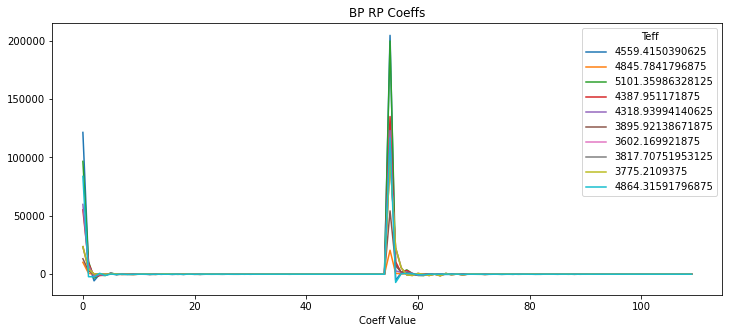

In [173]:
#Plot BP RP Coeffs
plt.figure(figsize=(12,5))
plt.title('BP RP Coeffs')
for i in range(10):
    plt.plot(xs[i], label=df['Teff'][i])
plt.legend(title='Teff')
plt.xlabel('Coeff')
plt.xlabel('Coeff Value')
plt.show()

## Plot relationship between coefficients and first BP (or RP) Coeff 

In [170]:
def plot_corr_BP(coeff, param):
    fig = plt.figure()
    plt.title('BP Coeff vs. APOGEE {}'.format(param))
    h = plt.hist2d(df[param], xs[:, coeff]/xs[:, 0], bins=80,  cmap='gist_earth_r', vmin=0, vmax=5)
    cbar = fig.colorbar(h[3], label='#Stars')
    cbar.ax.tick_params(labelsize=13)
    plt.ylabel('Ratio of #{} BP Coeff. Value to 0th BP Coeff. Value'.format(coeff))
    plt.xlabel('APOGEE {}'.format(param))
    plt.show()
    plt.close()
    
def plot_corr_RP(coeff, param):
    fig = plt.figure()
    plt.title('RP Coeff vs. APOGEE {}'.format(param))
    h = plt.hist2d(df[param], xs[:, 55+coeff]/xs[:, 55], bins=80,  cmap='gist_earth_r', vmin=0, vmax=5)
    cbar = fig.colorbar(h[3], label='#Stars')
    cbar.ax.tick_params(labelsize=13)
    plt.ylabel('Ratio of #{} RP Coeff. Value to 0th BP Coeff. Value'.format(coeff))
    plt.xlabel('APOGEE {}'.format(param))
    plt.show()
    plt.close()
    

## Plot BP coeffs. rel. to first BP Coeff as a func. of APOGEE params

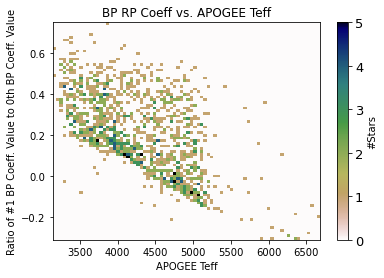

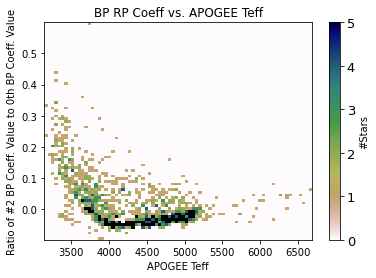

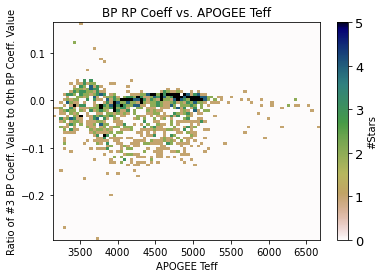

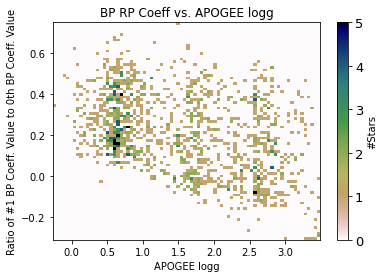

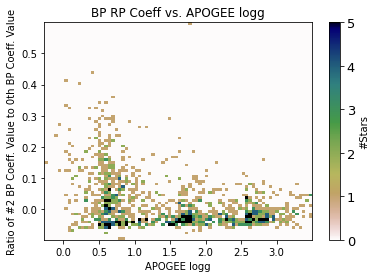

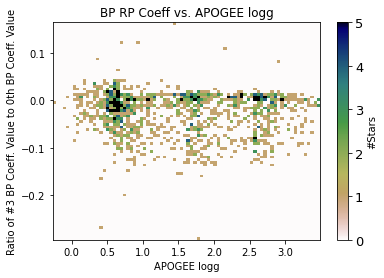

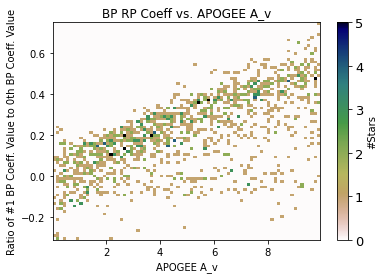

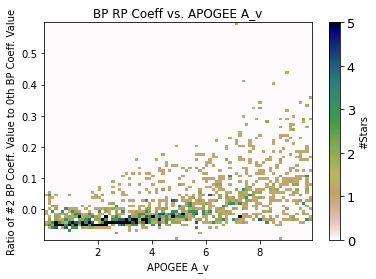

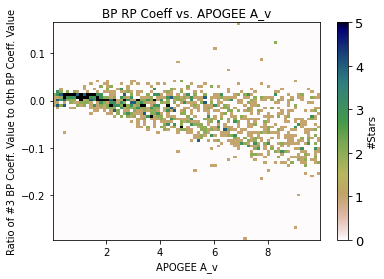

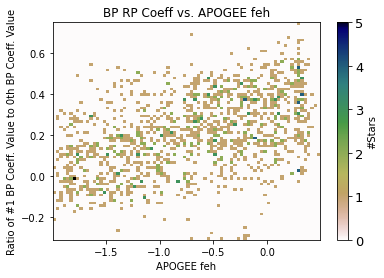

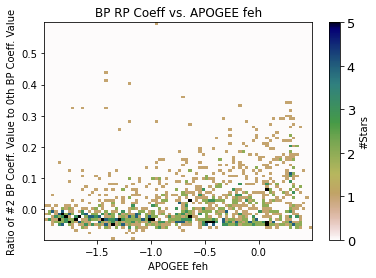

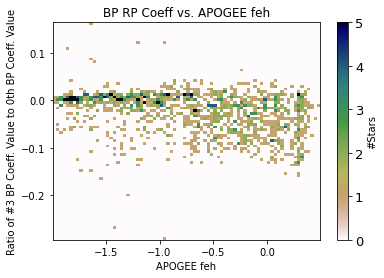

In [171]:
plot_corr(1, 'Teff')
plot_corr(2, 'Teff')
plot_corr(3, 'Teff')

plot_corr(1, 'logg')
plot_corr(2, 'logg')
plot_corr(3, 'logg')

plot_corr(1, 'A_v')
plot_corr(2, 'A_v')
plot_corr(3, 'A_v')

plot_corr(1, 'feh')
plot_corr(2, 'feh')
plot_corr(3, 'feh')

## Plot RP coeffs. rel. to first RP Coeff as a func. of APOGEE params


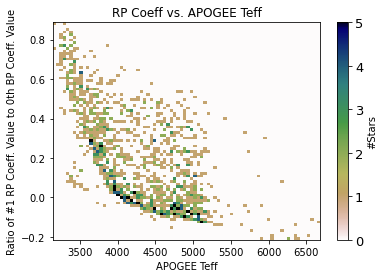

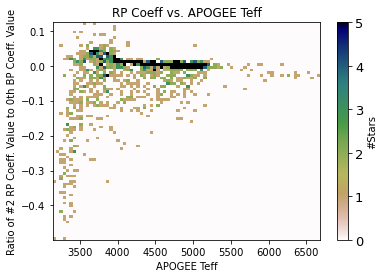

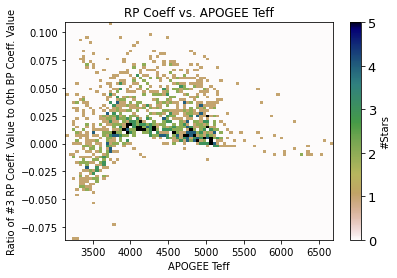

In [163]:
plot_corr_RP(1, 'Teff')
plot_corr_RP(2, 'Teff')
plot_corr_RP(3, 'Teff')

In [179]:
# def plot_corr(coeff, param):
#     plt.title('BP Coeff vs. APOGEE {}'.format(param))
#     h = ax.hist2d(df[param], xs[:, coeff]/xs[:, 0], bins=80,  cmap='gist_earth_r', vmin=0, vmax=5)
#     cbar = fig.colorbar(h[3], label='#Stars')
#     cbar.ax.tick_params(labelsize=13)
#     ax.set_ylabel('Ratio of #{} BP Coeff. Value to 0th BP Coeff. Value'.format(coeff))
#     ax.set_xlabel('APOGEE {}'.format(param))